<a href="https://colab.research.google.com/github/radoslaw626/TinyVGG/blob/main/TinyVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

torch.__version__

'2.2.1+cu121'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive/Git/TinyVGG
!ls

/content/drive/MyDrive/Git/TinyVGG
data  models  README.md  results  scripts  TinyVGG.ipynb


In [4]:
import os

if not os.path.exists('scripts'):
    os.makedirs('scripts')

if not os.path.exists('results'):
    os.makedirs('results')

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path}  directory already exists")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downloading pizza, steak, sushi data")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("unzipping")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi  directory already exists
downloading pizza, steak, sushi data
unzipping


In [7]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [8]:
walk_through_dir(image_path)

there are 2 directories and 0 images in data/pizza_steak_sushi
there are 3 directories and 0 images in data/pizza_steak_sushi/test
there are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
there are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
there are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
there are 3 directories and 0 images in data/pizza_steak_sushi/train
there are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
there are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
there are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [9]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [10]:
import random
from PIL import Image

# random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

print(image_class)

img = Image.open(random_image_path)

print(f"random image path: {random_image_path}")
img, img.size

sushi
random image path: data/pizza_steak_sushi/train/sushi/2021381.jpg


(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>, (512, 512))

(512, 512, 3)


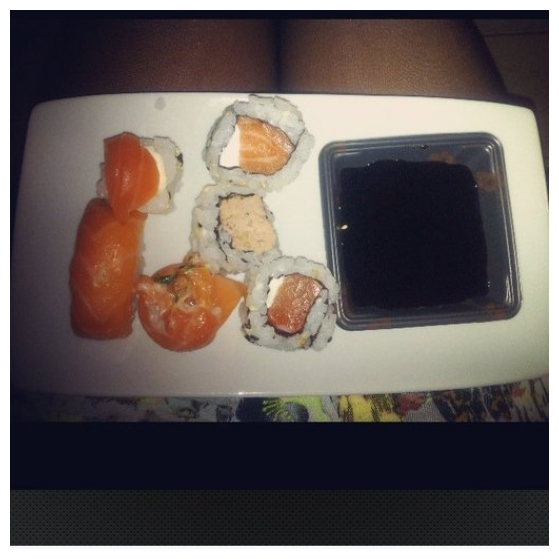

In [11]:
import matplotlib.pyplot as plt
import numpy as np

img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.axis(False)
print(img_as_array.shape)
plt.imshow(img_as_array)

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [13]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [14]:
data_transform(img).shape

torch.Size([3, 64, 64])

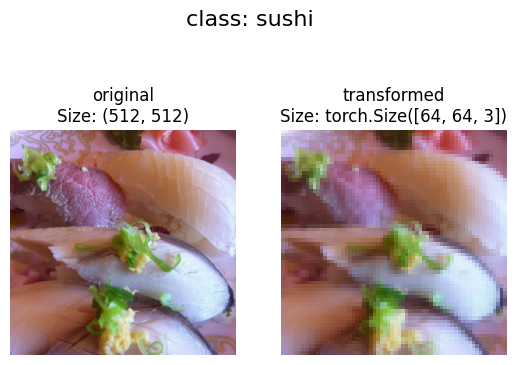

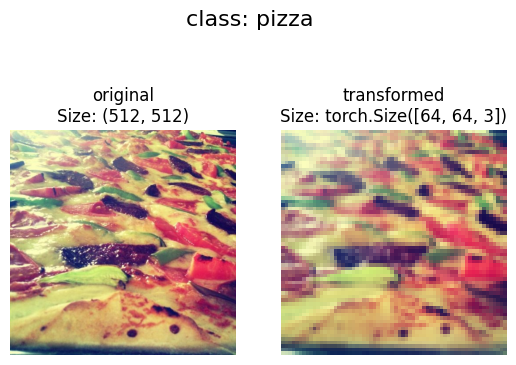

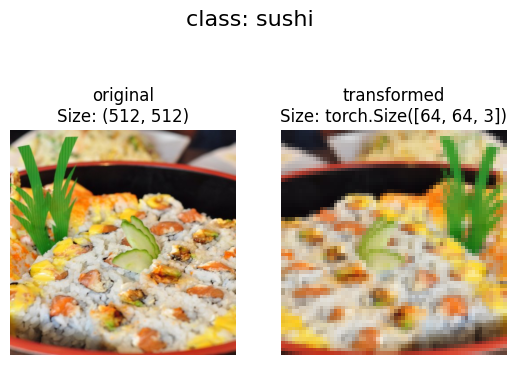

In [15]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)

      ax[1].imshow(transformed_image)
      ax[1].set_title(f"transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3)

In [16]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)


train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
len(train_data), len(test_data)

(225, 75)

In [20]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [21]:
img, label = train_data[0][0], train_data[0][1]
print(f"image tensor: {img}")
print(f"image shape: {img.shape}")
print(f"image datatype: {img.dtype}")
print(f"image label: {label}")
print(f"image datatype: {type(label)}")

image tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

original shape: torch.Size([3, 64, 64])
permute shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

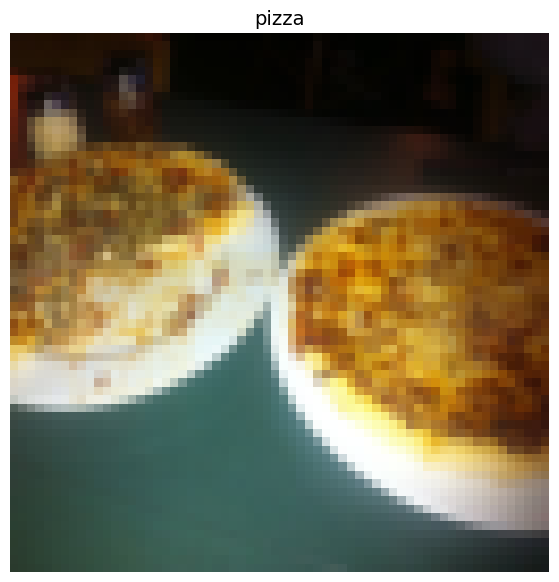

In [22]:
img_permute = img.permute(1, 2, 0)

print(f"original shape: {img.shape}")
print(f"permute shape: {img_permute.shape}")


plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

In [23]:
import os
os.cpu_count()

2

In [24]:
from torch.utils.data import DataLoader

BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7eece72a0c40>,
 <torch.utils.data.dataloader.DataLoader at 0x7eec11767c70>)

In [25]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [26]:
img, label = next(iter(train_dataloader))

print(f"image shape: {img.shape}")
print(f"label shape: {label.shape}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


image shape: torch.Size([1, 3, 64, 64])
label shape: torch.Size([1])


In [27]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [28]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [29]:
target_directory = train_dir
print(f"target dir: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [30]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"could not find any classes in {directory}")

  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx


In [31]:
find_classes(str(target_directory))

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [32]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [33]:
train_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()])

In [34]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7eebf3bbe3e0>,
 <__main__.ImageFolderCustom at 0x7eebf3bbfdf0>)

In [35]:
len(train_data), len(train_data_custom)

(225, 225)

In [36]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [37]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [38]:
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


In [39]:
def display_random_images (dataset: torch.utils.data.Dataset,
                           classes: List[str] = None,
                           n: int = 10,
                           display_shape: bool = True,
                           seed: int = None):
  if n > 10:
    n=10
    display_shape = False
    print(f"for display purposes n shouldnt be larger than 10")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

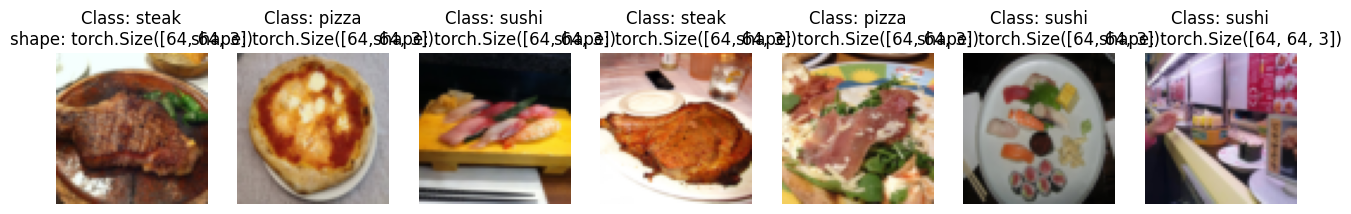

In [40]:
display_random_images(train_data,
                      n=7,
                      classes=class_names,
                      seed=None)

In [41]:
from torch.utils.data import DataLoader
BATCH_SIZE=32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7eebf3a3e950>,
 <torch.utils.data.dataloader.DataLoader at 0x7eebf3a3c6d0>)

In [42]:
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [43]:
from torchvision import transforms

train_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.ToTensor()
])

In [44]:
image_path

PosixPath('data/pizza_steak_sushi')

In [45]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/714866.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg')]

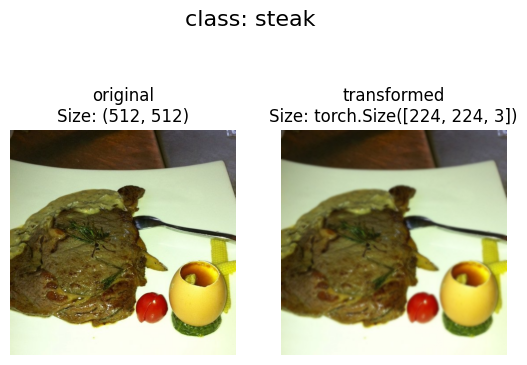

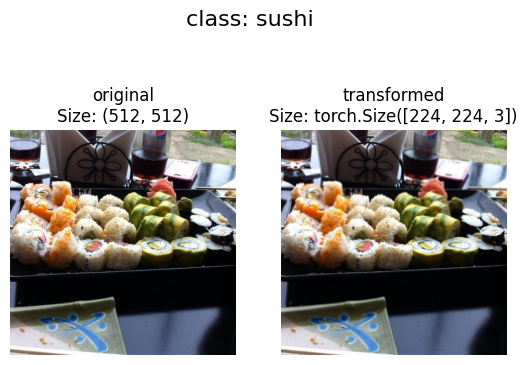

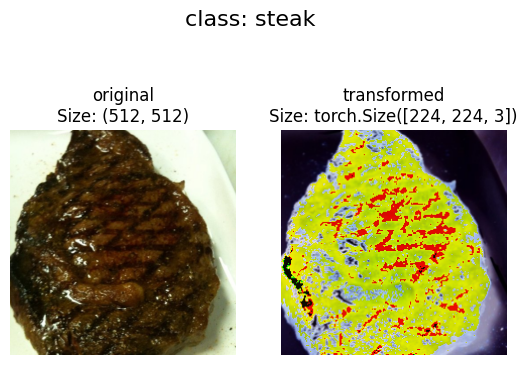

In [46]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

In [47]:
%%writefile scripts/data_setup.py

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
  train_dir: str,
  test_dir: str,
  train_transform: transforms.Compose,
  test_transform: transforms.Compose,
  batch_size: int,
  num_workers: int=NUM_WORKERS
):
  train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform,
                                  target_transform=None)

  test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform)

  class_names = train_data.classes

  train_dataloader = DataLoader(dataset=train_data,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=True,
                             pin_memory=True)
  test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

  return train_dataloader, test_dataloader, class_names

Overwriting scripts/data_setup.py


In [48]:
%%writefile scripts/engine.py

from typing import Dict, List, Tuple
from tqdm.auto import tqdm
import torch


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  model.eval()
  test_loss, test_acc = 0,  0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):

  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(
        model=model,
        dataloader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device)

    test_loss, test_acc = test_step(
        model=model,
        dataloader=test_dataloader,
        loss_fn=loss_fn,
        device=device)

    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
      )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

Overwriting scripts/engine.py


In [49]:
%%writefile scripts/model_builder.py

import torch

from torch import nn

class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))


Overwriting scripts/model_builder.py


In [50]:
%%writefile scripts/utils.py

import torch
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)


  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)



def load_model(model: torch.nn.Module, model_path: str) -> torch.nn.Module:

    model_path = Path(model_path)
    assert model_path.exists(), "Model file does not exist"
    assert model_path.suffix in ['.pt', '.pth'], "Model file should be a '.pt' or '.pth' file"

    print(f"[INFO] Loading model from: {model_path}")
    model.load_state_dict(torch.load(model_path))

    return model


def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

Overwriting scripts/utils.py


In [51]:
%%writefile scripts/train.py


import os
import json
import torch
from torchvision import transforms
import data_setup, engine, model_builder, utils
from timeit import default_timer as timer

NUM_EPOCHS = 50
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

device = "cuda" if torch.cuda.is_available() else "cpu"


simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
    ])


train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=simple_transform,
    test_transform=simple_transform,
    batch_size=BATCH_SIZE
)

model = model_builder.TinyVGG(input_shape=3,
                              hidden_units=HIDDEN_UNITS,
                              output_shape=len(class_names)).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=NUM_EPOCHS,
                       device=device)

with open('results/simple_data_model_results.json', 'w') as f:
    json.dump(results, f)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


utils.save_model(model=model,
                 target_dir="models",
                 model_name="simple_data_tinyvgg_model.pt")

Overwriting scripts/train.py


In [52]:
%%writefile scripts/train_augumented_data.py


import os
import json
import torch
from torchvision import transforms
import data_setup, engine, model_builder, utils
from timeit import default_timer as timer

NUM_EPOCHS = 50
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

device = "cuda" if torch.cuda.is_available() else "cpu"


simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
    ])

trivial_augumented_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
    ])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=trivial_augumented_transform,
    test_transform=simple_transform,
    batch_size=BATCH_SIZE
)

model = model_builder.TinyVGG(input_shape=3,
                              hidden_units=HIDDEN_UNITS,
                              output_shape=len(class_names)).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=NUM_EPOCHS,
                       device=device)

with open('results/augumented_data_model_results.json', 'w') as f:
    json.dump(results, f)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


utils.save_model(model=model,
                 target_dir="models",
                 model_name="augumented_data_tinyvgg_model.pt")

Overwriting scripts/train_augumented_data.py


In [53]:
!python scripts/train.py

  0% 0/50 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 1 | train_loss: 1.1051 | train_acc: 0.2500 | test_loss: 1.0970 | test_acc: 0.1979
  2% 1/50 [00:04<03:32,  4.34s/it]Epoch: 2 | train_loss: 1.1005 | train_acc: 0.3438 | test_loss: 1.0799 | test_acc: 0.5729
  4% 2/50 [00:07<02:43,  3.41s/it]Epoch: 3 | train_loss: 1.0882 | train_acc: 0.4453 | test_loss: 1.0766 | test_acc: 0.4536
  6% 3/50 [00:09<02:22,  3.03s/it]Epoch: 4 | train_loss: 1.0822 | train_acc: 0.4375 | test_loss: 1.0637 | test_acc: 0.4309
  8% 4/50 [00:12<02:13,  2.90s/it]Epoch: 5 | train_loss: 1.0364 | train_acc: 0.5781 | test_loss: 1.0591 | test_acc: 0.3125
 10% 5/50 [00:15<02:21,  3.14s/it]Epoch: 6 | train_loss: 0.9810 | train_acc: 0.5586 | test_loss: 1.0797 | test_acc: 0.3125
 12% 6/50 [00:19<02:30,  3.42s/it]Epoc

In [54]:
from scripts import model_builder, utils

model_0 = model_builder.TinyVGG(input_shape=3,
                                 hidden_units=10,
                                output_shape=3).to(device)
model_0 = utils.load_model(model=model_0, model_path="models/simple_data_tinyvgg_model.pt")
model_0

[INFO] Loading model from: models/simple_data_tinyvgg_model.pt


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [55]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [56]:
import json
model_0_results=''
with open('results/simple_data_model_results.json', 'r') as f:
    model_0_results = json.load(f)
model_0_results

{'train_loss': [1.1050678491592407,
  1.1004889905452728,
  1.088205263018608,
  1.0822171717882156,
  1.0364336520433426,
  0.9810297191143036,
  1.0189941227436066,
  0.9833607748150826,
  0.8027282748371363,
  0.8177291005849838,
  0.7825263366103172,
  0.8438392207026482,
  0.7866047471761703,
  0.7267812164500356,
  0.7436072304844856,
  0.8136200681328773,
  0.7789196781814098,
  0.8871698155999184,
  0.7602723985910416,
  0.8273594379425049,
  0.6609077220782638,
  0.9902388378977776,
  0.8431229293346405,
  0.8682706952095032,
  1.0321748554706573,
  0.8510747626423836,
  0.6805023120250553,
  0.7591086328029633,
  0.7029255777597427,
  0.6422359552234411,
  0.6005201033549383,
  0.7290370091795921,
  0.6594314575195312,
  0.576439805328846,
  0.6409424617886543,
  0.5649763531982899,
  0.5301745741162449,
  0.5499132499098778,
  0.5497349202632904,
  0.48285708017647266,
  0.46368536353111267,
  0.49802257493138313,
  0.4760511666536331,
  0.472110440954566,
  0.45030366629362

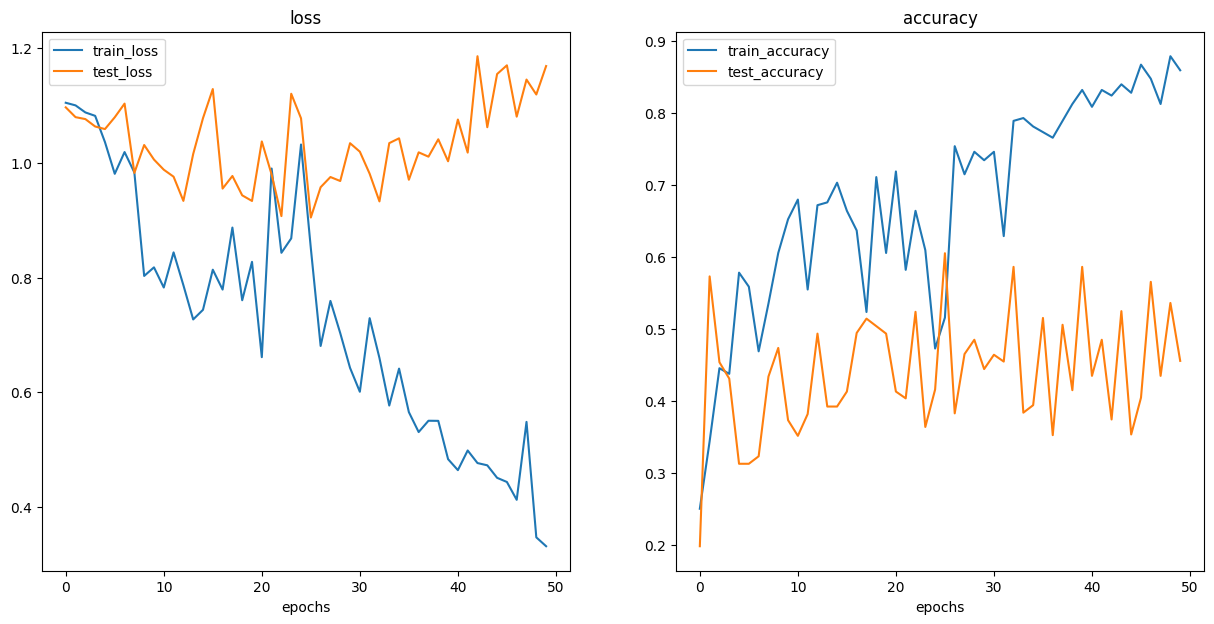

In [57]:
from scripts import utils
utils.plot_loss_curves(model_0_results)

In [58]:
!python scripts/train_augumented_data.py

  0% 0/50 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 1 | train_loss: 1.1016 | train_acc: 0.2812 | test_loss: 1.0947 | test_acc: 0.1979
  2% 1/50 [00:02<02:21,  2.90s/it]Epoch: 2 | train_loss: 1.0925 | train_acc: 0.4141 | test_loss: 1.1148 | test_acc: 0.1979
  4% 2/50 [00:07<02:54,  3.64s/it]Epoch: 3 | train_loss: 1.0860 | train_acc: 0.4141 | test_loss: 1.1365 | test_acc: 0.1979
  6% 3/50 [00:09<02:27,  3.13s/it]Epoch: 4 | train_loss: 1.1121 | train_acc: 0.2930 | test_loss: 1.1516 | test_acc: 0.1979
  8% 4/50 [00:12<02:15,  2.95s/it]Epoch: 5 | train_loss: 1.0872 | train_acc: 0.4141 | test_loss: 1.1436 | test_acc: 0.1979
 10% 5/50 [00:14<02:09,  2.87s/it]Epoch: 6 | train_loss: 1.1008 | train_acc: 0.2930 | test_loss: 1.1463 | test_acc: 0.1979
 12% 6/50 [00:18<02:13,  3.04s/it]Epoc

In [59]:
from scripts import model_builder, utils

model_1 = model_builder.TinyVGG(input_shape=3,
                                 hidden_units=10,
                                output_shape=3).to(device)
model_1 = utils.load_model(model=model_1, model_path="models/augumented_data_tinyvgg_model.pt")
model_1

[INFO] Loading model from: models/augumented_data_tinyvgg_model.pt


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [60]:
import json
model_1_results=''
with open('results/augumented_data_model_results.json', 'r') as f:
    model_1_results = json.load(f)
model_1_results

{'train_loss': [1.1016158312559128,
  1.092468023300171,
  1.0859686806797981,
  1.1120654940605164,
  1.0872360467910767,
  1.1008029878139496,
  1.0945425927639008,
  1.1162013709545135,
  1.0875367522239685,
  1.0995252430438995,
  1.0804717391729355,
  1.0701365321874619,
  1.0557794943451881,
  1.0591507032513618,
  1.0165246427059174,
  1.04216730594635,
  0.9819790050387383,
  0.9443301409482956,
  0.8996198438107967,
  0.938131295144558,
  0.9696307107806206,
  0.9566351845860481,
  1.1296279728412628,
  1.0013355985283852,
  1.0591061487793922,
  0.9970709681510925,
  0.9986421838402748,
  0.9513846784830093,
  0.8624453581869602,
  1.076472781598568,
  0.9261802062392235,
  0.8626583069562912,
  1.0243188217282295,
  1.3083908334374428,
  1.006926216185093,
  1.0465466752648354,
  0.8903350010514259,
  0.9595968797802925,
  1.055309683084488,
  0.992645613849163,
  0.9075513035058975,
  0.8957282602787018,
  0.9118192344903946,
  0.9332115426659584,
  0.9790037870407104,
  0.

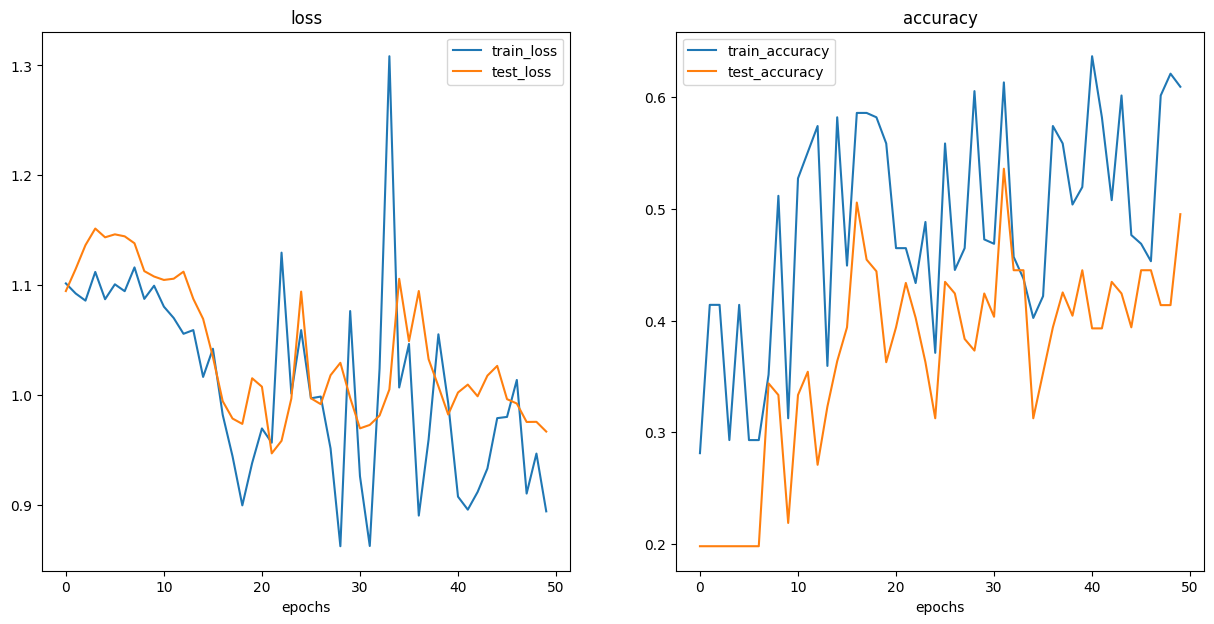

In [61]:
from scripts import utils
utils.plot_loss_curves(model_1_results)

In [62]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.105068,0.250000,1.097042,0.197917
1,1.100489,0.343750,1.079944,0.572917
2,1.088205,0.445312,1.076571,0.453598
3,1.082217,0.437500,1.063662,0.430871
4,1.036434,0.578125,1.059134,0.312500
5,0.981030,0.558594,1.079726,0.312500
6,1.018994,0.468750,1.103578,0.322917
7,0.983361,0.535156,0.982548,0.433712
8,0.802728,0.605469,1.031317,0.473485
9,0.817729,0.652344,1.005912,0.373106


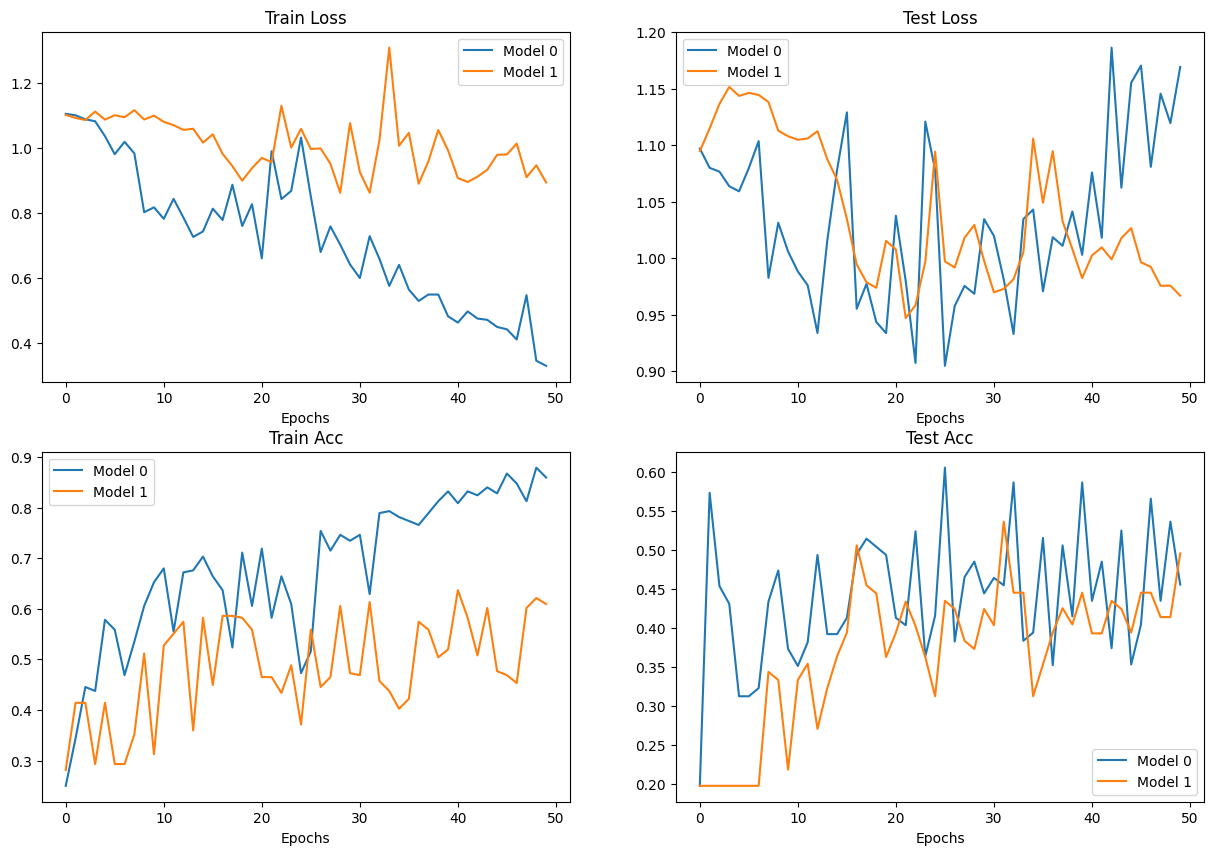

In [63]:
plt.figure(figsize=(15, 10))

epochs = range(len(model_0_df))

plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();

In [64]:
import requests

custom_image_path = data_path / "pizza.jpg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://t4.ftcdn.net/jpg/06/53/54/87/360_F_653548703_MwhAw9fCtvFSaroiErTxRM5j3LogV55c.jpg")
    print(f"downloading {custom_image_path}")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")

data/pizza.jpg already exists


In [65]:
custom_image_path

PosixPath('data/pizza.jpg')

In [66]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[1, 1, 1,  ..., 6, 6, 7],
         [1, 1, 1,  ..., 6, 6, 7],
         [0, 0, 0,  ..., 6, 6, 7],
         ...,
         [0, 0, 0,  ..., 2, 2, 2],
         [0, 0, 0,  ..., 5, 5, 5],
         [0, 0, 0,  ..., 5, 5, 5]],

        [[0, 0, 0,  ..., 4, 4, 5],
         [0, 0, 0,  ..., 4, 4, 5],
         [0, 0, 0,  ..., 4, 4, 5],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 5, 5, 6],
         [0, 0, 0,  ..., 5, 5, 6],
         [0, 0, 0,  ..., 5, 5, 6],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 360, 540])
Custom image datatype: torch.uint8


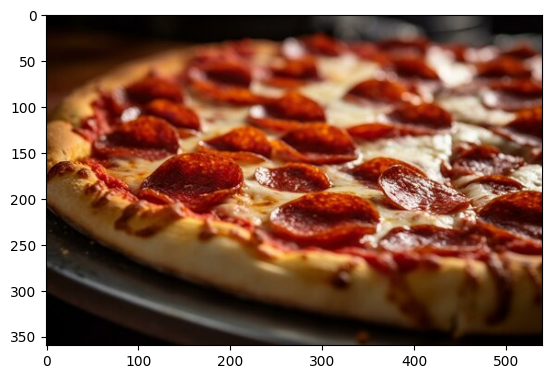

In [67]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

In [68]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0235, 0.0235, 0.0275],
         [0.0039, 0.0039, 0.0039,  ..., 0.0235, 0.0235, 0.0275],
         [0.0000, 0.0000, 0.0000,  ..., 0.0235, 0.0235, 0.0275],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.0196],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.0196]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0157, 0.0196],
         [0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0157, 0.0196],
         [0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0157, 0.0196],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.0235],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.0235],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.

In [69]:
from torchvision import transforms
custom_image_transform = transforms.Compose([
                                             transforms.Resize(size=(64, 64))
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"original shape: {custom_image.shape}")
print(f"transformed shape: {custom_image_transformed.shape}")

original shape: torch.Size([3, 360, 540])
transformed shape: torch.Size([3, 64, 64])


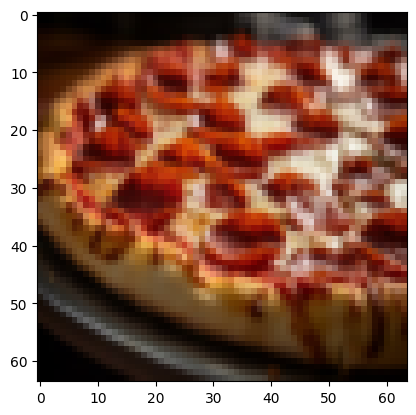

In [70]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [71]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [72]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0961, -1.2070,  0.6095]])

In [73]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3398, 0.0923, 0.5678]])

In [74]:
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([2])

In [75]:
class_names[custom_image_pred_label]

'sushi'

In [76]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  target_image = target_image / 255.

  if transform:
    target_image = transform(target_image)

  model.to(device)

  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)

    target_image_pred = model(target_image.to(device))
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

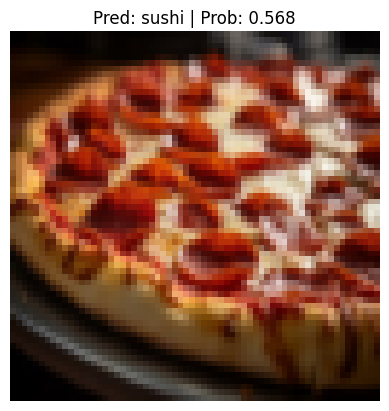

In [77]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)